# Performance Imapcts
The code in this notebook is used to demonstrate the performance impacts produced by training a model using Differentially Private gradient optimization techniques 
using PyTorch and Opacus.


In [7]:
# This cell changes display settings for the notebook.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [8]:
# import neccesary python modules
from opacus.utils import module_modification
from opacus.dp_model_inspector import DPModelInspector
from opacus import PrivacyEngine
from random import randint
from torch.utils.tensorboard import SummaryWriter
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [9]:
# This cell contains some helper functions used to help train and visualize model training.
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
#     writer.close()

def accuracy(preds, labels):
    return (preds == labels).mean()

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[idx],
            probs[idx] * 100.0,
            classes[labels[idx]]),
            color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def get_data_set(train,dataset):
    transform = transforms.Compose([
        transforms.Resize(255),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ])

    # datasets
    if dataset == 'mnist':
        return torchvision.datasets.MNIST('./data',
            download=True,
            train=train,
            transform=transform)
    else:
        print(f"ERROR LOADING DATASET FOR: {dataset}")
    
def get_class_constants(dataset):
    if dataset == 'mnist':
        return ('zero', 'one', 'two', 'three', 'four','five', 'six', 'seven', 'eight', 'nine')
    elif dataset == 'cifar':
        return ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 
    else:
        print(f"ERROR LOADING CLASS CONSTANTS FOR: {dataset}")        

def get_model_object(num_classes):
#     if modeltype == 'alexnet':
    return torchvision.models.alexnet(num_classes)

        
def setup_tensorboard_for_experiment(exp_name):
    # writer = SummaryWriter('runs/reg_mnist_experiment_1')
    writer = SummaryWriter('runs/' + exp_name)
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    images = images.to(device_name)
    labels = labels.to(device_name)

    # create grid of images
    img_grid = torchvision.utils.make_grid(images)

    # show images
    matplotlib_imshow(img_grid.cpu(), one_channel=True)

    # write to tensorboard
    writer.add_image('four_mnist_images', img_grid)

    # add graph?
    # writer.add_graph(net, images)
    writer.close()

    # select random images and their target indices
    images, labels = select_n_random(trainset.data, trainset.targets)

    # get the class labels for each image
    class_labels = [classes[lab] for lab in labels]

    # log embeddings
    features = images.view(-1, 28 * 28)
    writer.add_embedding(features,
                        metadata=class_labels,
                        label_img=images.unsqueeze(1))
#     writer.close()
    return writer

def save_model(exp_name):
#     print(str('./trained_models/'+exp_name+'.pth'))
    torch.save(net.state_dict(), str('./trained_models/'+exp_name+'.pth'))
    
def train_model(exp_name,num_epochs,device_name,writer):
    DELTA = 1e-3

    running_loss = 0.0
    losses = []
    top1_acc=[]
    virtual_batch_rate = VIRTUAL_BATCH_SIZE/BATCH_SIZE
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        for i, data in enumerate(trainloader, 0):

            images, target = data
            images = images.to(device_name)
            target = target.to(device_name)

            output = net(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)
            running_loss += loss.item() 
            loss.backward()
            if dp:
                if ((i + 1) % virtual_batch_rate == 0) or ((i + 1) == len(trainloader)):
                    optimizer.step()
                    optimizer.zero_grad()
                else:
                    optimizer.virtual_step() # take a virtual step
            else:
                optimizer.step()
                optimizer.zero_grad()
            if i % 200 == 199:
                # If you will be training over a large number of epochs/dataset
                # it may be helpful to save the progress of training periodically.
                # Do that by uncommenting the line below:
#                 save_model(exp_name) # uncomment to save progress during training
                if dp:
                    epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(DELTA)
                    print(
                        f"\tTrain Epoch: {epoch} \t"
                        f"Loss: {np.mean(losses):.6f} "
                        f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                        f"(ε = {epsilon:.2f}, δ = {DELTA})"
                    )
                else:
                    print(
                        f"\tTrain Epoch: {epoch} \t"
                        f"Loss: {np.mean(losses):.6f} "
                        f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    )
                    
                # Here we output Training metrics to TensorBoard so we can see 
                # how the loss is changing..
                writer.add_scalar('training loss',running_loss/200,epoch * len(trainloader) + i)

                # Pass tensorboard a set of predicted images, to demonstrate class accuracy during training
                writer.add_figure('predictions vs. actuals',plot_classes_preds(net, images, labels),global_step=epoch * len(trainloader) + i)
                running_loss = 0.0
    
    save_model(exp_name) 
    writer.close()
    print('Finished Training')

# The following cell contains variable names that are relevant in the training of the model
 - `experiment_name`: Name given to the saved model, and also how it will be named in TensorBoard
 - `experiment_n`: Tracks the current experiment we are running - note change this or will overwrite trained models
 - `dataset`: Name of the preloaded PyTorch dataset to experiment with
 - `dp`: Should the model be trained using DP?
 - `device_name`: 'cpu' or 'cuda', specifies torch device
 - `LR`: learning rate for the model

In [10]:
experiment_name = ''
experiment_n= 0
dataset     = 'mnist'  # not being used currently
dp          = True
device_name = 'cuda'

BATCH_SIZE=8
VIRTUAL_BATCH_SIZE=128
LR = 9e-4
m = .9

# DP Engine parameters
NOISE_MULT = 1.5
MAX_GRAD_NORM = 1.2

In [11]:
# This cell is used to load models for display in TensorBoard

# Get training and testing dataset
trainset=get_data_set(True,dataset)
testset=get_data_set(False,dataset)

# Get training and testing dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)

# constant for classes
classes = get_class_constants(dataset)

# get the model
net = get_model_object(len(classes)).to(device_name)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=m)
# if dp:


# Impacts on performance
There are a few key items that seems to have the most notable impact on performance. First, memory required to load a single training batch into memory during training. 
Image resolution and batch size play an important role in the amount of memory required to train the network. Similarly, learning rates and number of training epochs impacts the 
overall performance of the network after training. The differentially private model on average tended to require up to twice as many training epochs to converge to the same 
value using the same training data and network structure, just adding differentialy privacy to the network's optimizer. Running the code below demonstrates the different rates 
at which the losses of the differentially private models converge relative to one another. Likewise, learning rates can be adjusted such to demonstrate how learning rates 
impact training in both differentially private and vanilla models.

More specific to the differentially private models, `NOISE_MULT` and `MAX_GRAD_NORM` are parameters that are relevant while training differentially private models. The optimizer 
uses these parameters to determine how exactly it should apply convolutions and transformations that are part of performing differentially private gradient optimization. From our 
experiments it seems that a higher `NOISE_MULT`, (and furthermore higher level of noise applied during DP gradient optimization) tended to perform better than models using smaller 
values.

When the cells below are executing, make sure you have tensorboard running using: `tensorboard --logdirs=runs`

mnist_0_dp_874


/home/krizzly/school/5152/project/torchenv2/lib/python3.7/site-packages/opacus/privacy_engine.py:113: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


	Train Epoch: 0 	Loss: 11.571669 Acc@1: 0.000000 (ε = 0.26, δ = 0.001)
	Train Epoch: 0 	Loss: 10.192690 Acc@1: 0.000000 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 9.458576 Acc@1: 0.000000 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 8.914884 Acc@1: 0.031250 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 8.428239 Acc@1: 0.187500 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 7.972111 Acc@1: 0.906250 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 7.556262 Acc@1: 2.205357 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 7.197550 Acc@1: 3.679688 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 6.880509 Acc@1: 5.270833 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 6.606619 Acc@1: 6.675000 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 6.350371 Acc@1: 8.056818 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 6.127727 Acc@1: 9.291667 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 5.916571 Acc@1: 10.625000 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 	Loss: 5.730508 Acc@1: 11.638393 (ε = 0.27, δ = 0.001)
	Train Epoch: 0 

/home/krizzly/school/5152/project/torchenv2/lib/python3.7/site-packages/opacus/privacy_engine.py:273: UserWarning: PrivacyEngine expected a batch of size 128 but the last step received a batch of size 96. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "


	Train Epoch: 1 	Loss: 3.401680 Acc@1: 28.086039 (ε = 0.28, δ = 0.001)
	Train Epoch: 1 	Loss: 3.353613 Acc@1: 28.607595 (ε = 0.28, δ = 0.001)
	Train Epoch: 1 	Loss: 3.308180 Acc@1: 29.089506 (ε = 0.28, δ = 0.001)
	Train Epoch: 1 	Loss: 3.263953 Acc@1: 29.590361 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 3.221672 Acc@1: 30.076471 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 3.181039 Acc@1: 30.544540 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 3.141507 Acc@1: 31.011236 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 3.102984 Acc@1: 31.510989 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 3.065875 Acc@1: 31.977151 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 3.030515 Acc@1: 32.414474 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 2.995546 Acc@1: 32.858247 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 2.961897 Acc@1: 33.279040 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 2.929677 Acc@1: 33.673267 (ε = 0.29, δ = 0.001)
	Train Epoch: 1 	Loss: 2.897170 Acc@1: 34.141990 (ε = 0.29, δ = 0.001)
	Train

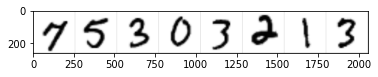

In [6]:
privacy_engine = PrivacyEngine(
    net,
    batch_size=VIRTUAL_BATCH_SIZE,
    sample_size=len(trainset),
    alphas=range(2,32),
    noise_multiplier=NOISE_MULT,
    max_grad_norm=MAX_GRAD_NORM
)   
privacy_engine.attach(optimizer)
LR = 9e-5
experiment_name = f'{dataset}_{experiment_n}_dp'+ '_' +str(randint(100, 999))
print(experiment_name)
writer = setup_tensorboard_for_experiment(experiment_name)
train_model(experiment_name,3,device_name,writer)

In [ ]:
# Trains a model WITHOUT differential privacy enabled
LR= 9e-5
dp = False
experiment_name = f'{dataset}_{experiment_n}'+ '_' +str(randint(100, 999))
print(experiment_name)
writer = setup_tensorboard_for_experiment(experiment_name)
train_model(experiment_name,3,device_name,writer)

mnist_0_788
	Train Epoch: 0 	Loss: 1.631808 Acc@1: 57.750000 
	Train Epoch: 0 	Loss: 0.955851 Acc@1: 74.906250 
	Train Epoch: 0 	Loss: 0.712178 Acc@1: 81.125000 
	Train Epoch: 0 	Loss: 0.571267 Acc@1: 84.750000 
	Train Epoch: 0 	Loss: 0.476011 Acc@1: 87.187500 
	Train Epoch: 0 	Loss: 0.419954 Acc@1: 88.677083 
